# Lesson 4: Model fitting on experinmental data

In the previous lessons we have been simulating data to study population dynamics of different species using the `Lotka-Volterra`.  In this particular lesson we are going to focus on using experimental data specifically bacteria co-culture data, to study bacteria relationships. We will use the data to identify model parameters and fit the model to the experinmental data. 

The generation and description of the data used in this lesson could be found [here](https://journals.asm.org/doi/10.1128/aem.01338-07)

## Data extraction and visualisation

In [68]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import numpy as np
import warnings
from scipy.optimize import differential_evolution


In [9]:
# get all the file in the folder

files = os.listdir("/Users/edwin/Downloads/co-culture_data/Bacteria/")
# print(files)

In [10]:
## get the first file into a dataframe
data = pd.read_csv('/Users/edwin/Downloads/co-culture_data/Bacteria/'+ files[0])
splitnames = files[0].split('.')
filename = splitnames[0]
data.rename(columns = {"logCFU": filename}, inplace = True) 

In [11]:
## Extract all the data from all the csv files into one dataframe

all_dat = [] 
for i in range(len(files)):
    df1 = pd.read_csv('/Users/edwin/Downloads/co-culture_data/Bacteria/'+ files[i], index_col=0, header=0)
    splitnames = files[i].split('.')
    filename = splitnames[0]
    df1.rename(columns = {"logCFU": filename}, inplace = True)
    all_dat.append(df1)
df2 = pd.concat(all_dat, axis=1)


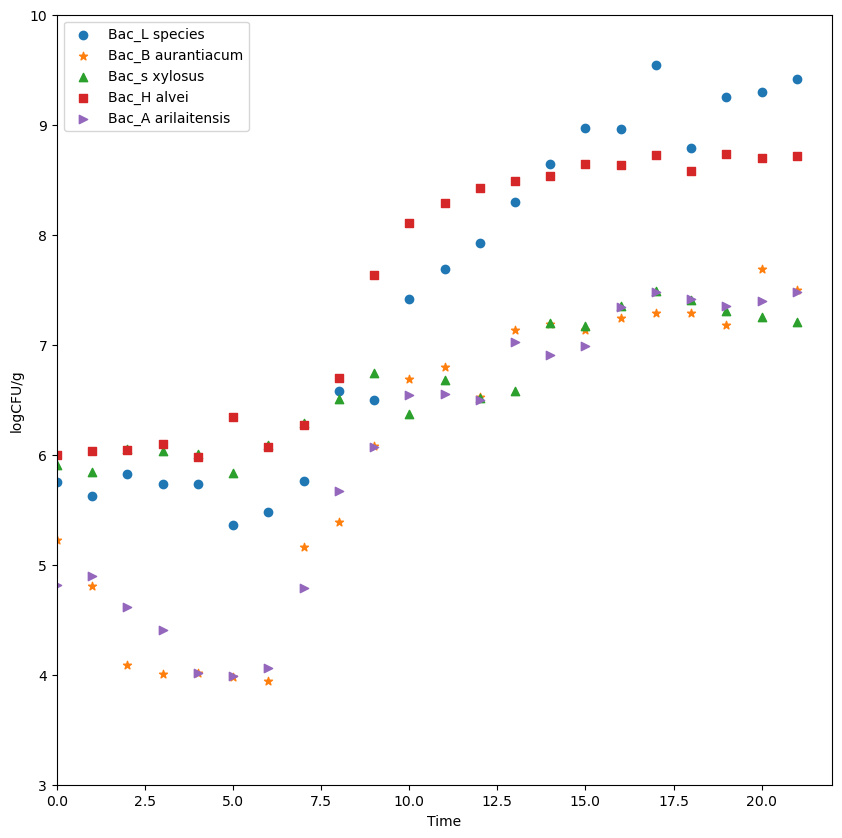

In [12]:
# Plot the data

plt.figure(figsize=(10,10))
markers = ["o" , "*" , "^" , "s", ">"]
for i in range(len(df2.columns)):
    mi = markers[i]
    plt.scatter(df2.index,df2[f'{df2.columns[i]}'], alpha=1, marker=mi, label = f'{df2.columns[i]}')

plt.xlim(0, 22)
plt.ylim(3, 10)
plt.ylabel('logCFU/g')
plt.xlabel('Time')
plt.legend()
plt.show()

## Model building and fitting

### `Curve_fit` function

In [13]:
# Get the names of the species from the dataframe
species_names = df2.columns

In [14]:
### Build a Generalized lotka-volterra model

NUM_SPECIES = len(species_names)
def generalized_lotka_volterra(t, *params):
    growth_rates = np.array(params[:NUM_SPECIES])
    interactions = np.array(params[NUM_SPECIES:]).reshape((NUM_SPECIES, NUM_SPECIES))

    # initial_pop = initial
    def model(populations, t):
        dX = []
        for i, x in enumerate(populations):
            dx = growth_rates[i]*x
            
            interaction = 0
            for j in range(NUM_SPECIES):
                interaction += interactions[i][j]*x*populations[j]
    
            dx += interaction
            dX.append(dx)
        return dX

    solution = odeint(model, initial_populations, t)
    return solution.ravel()

In [15]:
# get the data out of the dataframe
time_data = np.array(df2.index)

# get population data
population_data = np.zeros((len(time_data), len(species_names)))
for i, species in enumerate(species_names):
    species_pop = df2[species].to_numpy()
    population_data[:,i] = species_pop


In [64]:
## Get initial population from the data
initial_populations = []
for i in range(len(df2.columns)):
    initial_populations.append(df2.iloc[0, i]) 

guess = [1 for _ in range(NUM_SPECIES)] + [0]*(NUM_SPECIES*NUM_SPECIES)

In [63]:
# Fit generalized lotka-volterra using curve fit

population_data_flattened = population_data.flatten()
params, cov = curve_fit(generalized_lotka_volterra, time_data, population_data_flattened, p0=guess)
fitted_results = generalized_lotka_volterra(time_data, *params).reshape(len(time_data),NUM_SPECIES)

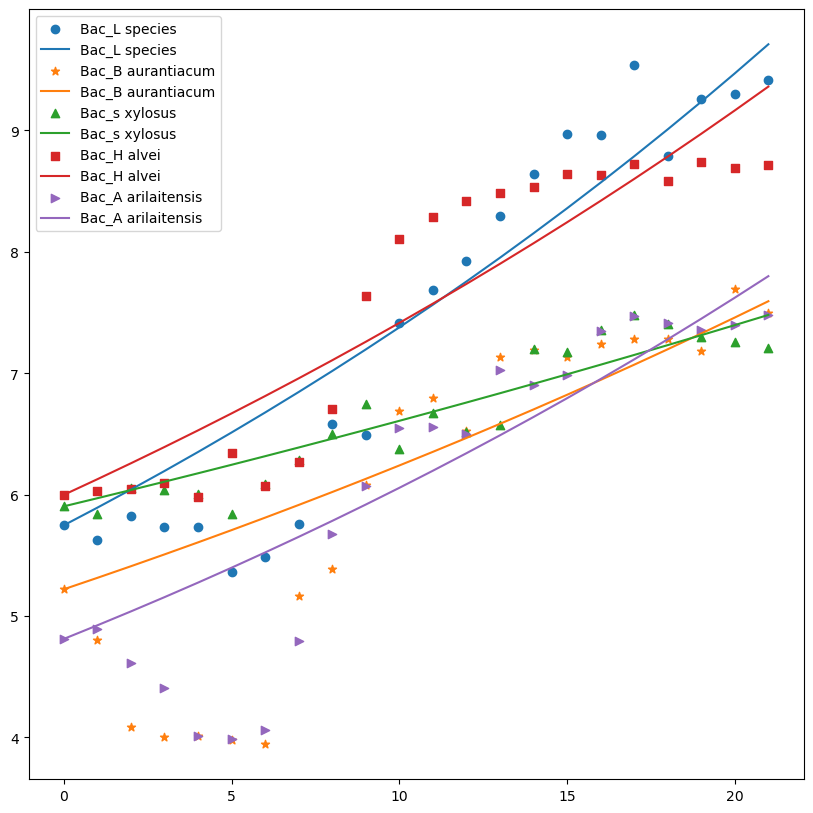

In [62]:
# plot the results against the origingal data

plt.figure(figsize=(10,10))
markers = ["o" , "*" , "^" , "s", ">"]
for i in range(NUM_SPECIES):
    plt.scatter(time_data, population_data[:, i], marker=markers[i], label=species_names[i])
    plt.plot(time_data, fitted_results[:,i], label=species_names[i])

plt.legend()
plt.show()

### Model-fitting - Differential Evolution

`Differential Evolution (DE)` is a type of evolutionary algorithm and a very effective heuristic for global optimization over continuous spaces. `DE` algorithm allows us to optimize parameters in the Generalized Lotka-Volterra (GLV) model, which includes setting up an objective function for optimization, and then using DE to find the best parameters that fit the model to given data or desired outcomes. 

In [66]:
# Define the objective function for optimization
def objective(params, t_data, observed_data):
    # Generate model predictions
    predictions = generalized_lotka_volterra(t_data, *params)
    
    # flatten results
    predictions_flattened = predictions.flatten()

    # Calculate sum of squared differences
    ssd = np.sum((observed_data - predictions_flattened) ** 2)
    return ssd

In [72]:
# Define bounds for each parameter (growth rates and interactions)
bounds = [(-1, 1)] * NUM_SPECIES + [(-0.1, 0.1)] * (NUM_SPECIES * NUM_SPECIES)

# Perform the differential evolution optimization
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")   
    result = differential_evolution(
        objective, 
        bounds, 
        args=(time_data, population_data_flattened),
        strategy='best1bin', 
        maxiter=1000, 
        popsize=15,
        tol=0.01, 
        mutation=(0.5, 1), 
        recombination=0.7
    )

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000565355216D+01   r2 =  0.4057868698935D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000565355216D+01   r2 =  0.4057868698935D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000565355216D+01   r2 =  0.4057868698935D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000565355216D+01   r2 =  0.4057868698935D-15
 lsoda--  warning..internal t (=r1) 

In [73]:
fitted_results2 = generalized_lotka_volterra(time_data, *result.x).reshape(len(time_data),NUM_SPECIES)

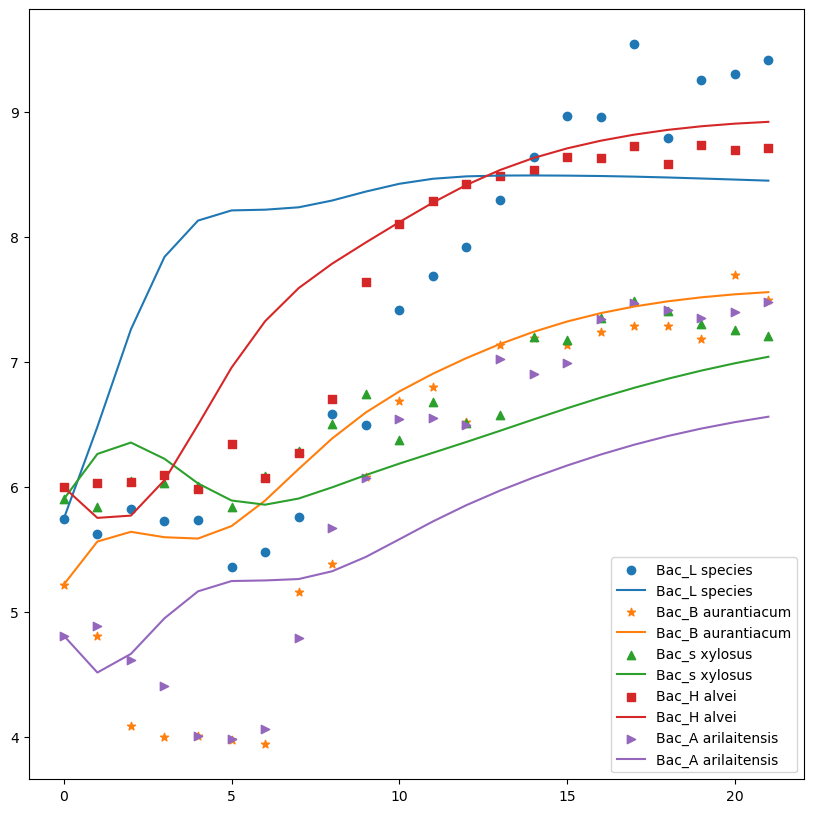

In [74]:
plt.figure(figsize=(10,10))
for i in range(NUM_SPECIES):
    plt.scatter(time_data, population_data[:, i], marker=markers[i], label=species_names[i])
    plt.plot(time_data, fitted_results2[:,i], label=species_names[i])

plt.legend()
plt.show()